# find regions where trades are within a certain band

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
tickerpair="LTCUSDT"
interval="5m"
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']
years=sorted(set([g.split("_")[2] for g in glob(f"kline_data\\{tickerpair}/*")]))

In [2]:
%%time
df = [pd.read_csv(g) for g in sorted(glob(f"kline_data\\{tickerpair}/*")) if f"_{interval}.csv" in g]
df = pd.concat(df, ignore_index=True).drop_duplicates().reset_index(drop=True)

dfmpl=df[["open_time","open","high","low","close","volume"]]
dfmpl = dfmpl.rename(columns={"open_time":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
dfmpl=dfmpl.set_index("Date")
dfmpl.index = pd.to_datetime(dfmpl.index,unit="ms")
print(len(dfmpl))
dfmpl=dfmpl.iloc[-15000:]

558410
CPU times: total: 1.45 s
Wall time: 2.26 s


In [3]:
# len(os.listdir("kline_data")),os.listdir("kline_data")

# use the gradient of the std/mean instead

CPU times: total: 594 ms
Wall time: 691 ms


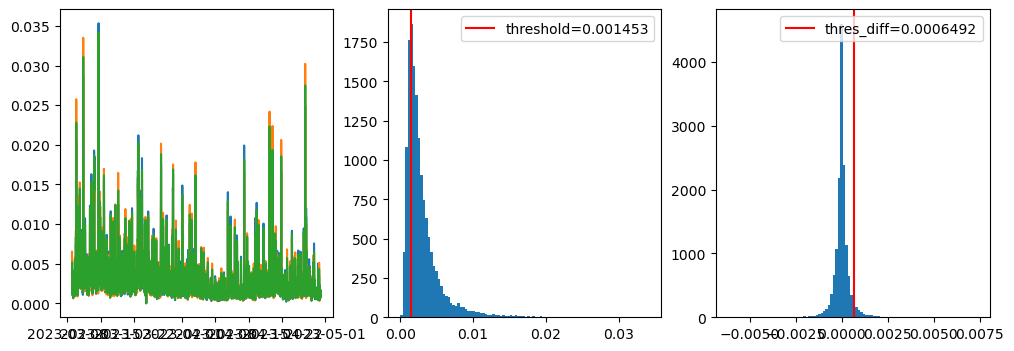

In [4]:
%%time
xvals=np.arange(len(dfmpl.Close))
rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
r_std_mean_diff = rolling_std_mean.diff()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
ax1.plot(rolling_high_std_mean)
ax1.plot(rolling_low_std_mean)
ax1.plot(rolling_std_mean)
n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
ax2.legend()
ax3.hist(r_std_mean_diff,bins=100)
thres_diff = np.percentile(r_std_mean_diff.values[np.where(~np.isnan(r_std_mean_diff.values))],95)
#thres_diff=0.0004
ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
ax3.legend()
#thres = 0.001
mkoffset = 1.01
crossings = np.where(np.diff(r_std_mean_diff>thres_diff,1))[0]
scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
crossup=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)>0)[0]
scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
crossdn=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)<0)[0]
scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals]
vlines = [dfmpl.index[i] for i in xvals if i in crossings ]
my_vlines=[i for i in xvals if i in crossings ]

In [5]:
# %%time
# apds = [ 
#     mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"), 
#     mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
#     mpf.make_addplot(scatterdn,color='r',type='scatter',marker="v"),
#        ]
# fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",mav=[10,20], 
#          returnfig=True,figsize=(20*1.5,7*1.5),panel_ratios=(1,1),warn_too_much_data=2000)#,figratio=(1,1),figscale=1.5)
# for ax in axlist[:]:
#     for vline in my_vlines:
#         ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
# mpf.show()

In [6]:
%%time
predict = [] # capture data
result= [] 
entry_exit_pairs=(np.where(~np.isnan(scatterup))[0],np.where(~np.isnan(scatterdn))[0])
for entry,exit in zip(*entry_exit_pairs):
    if entry-2<0:
        continue
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    predict.append( (s_1.Close-s_1.Open,s.Close-s.Open) )
    result.append( s2.Close-s.Close )
pred_sign = np.sign(predict,out=np.ones_like(np.asarray(predict))*-1.,where=np.asarray(predict)!=0)
true_sign = np.sign(result,out=np.ones_like(np.asarray(result))*-1.,where=np.asarray(result)!=0)

CPU times: total: 78.1 ms
Wall time: 101 ms


In [7]:
%%time
clf = RandomForestClassifier(max_depth=2, random_state=0)
lastNsamples = int(len(result)*0.1)
print("total results=",len(result) ,"lastN",lastNsamples)
clf.fit(pred_sign[:-lastNsamples], true_sign[:-lastNsamples])
predicted_result = clf.predict(pred_sign)
confusion_matrix(true_sign[-lastNsamples:], predicted_result[-lastNsamples:])


total results= 320 lastN 32
CPU times: total: 141 ms
Wall time: 189 ms


array([[ 7,  7],
       [ 4, 14]], dtype=int64)

In [8]:
%%time
profit=[] # implement backtesting for this strat
trade_durations = []
concated_df0=[]
for entry,exit,buy in zip(*entry_exit_pairs,predicted_result):#[-lastNsamples:]: 
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit] 
    gains= buy*(s2.Close-s.Close)/(s.Close)
    profit.append(gains)
    indd=dfmpl.iloc[[entry,exit]].index
    diff = indd[1].to_datetime64()-indd[0].to_datetime64()
    trade_hr = int(diff)*1e-9/3600
    trade_durations.append( trade_hr )
    concated_df0.append( dfmpl.iloc[entry-1:exit+1] ) 
    print(dfmpl.iloc[entry-1:exit+1])
    print("*"*8,s.Close,s2.Close,buy,gains,entry,exit)


                      Open   High    Low  Close    Volume
Date                                                     
2023-03-09 16:40:00  83.94  83.94  83.66  83.74  2333.412
2023-03-09 16:45:00  83.73  83.89  83.38  83.57  6369.017
2023-03-09 16:50:00  83.56  83.57  83.21  83.53  2824.127
******** 83.74 83.53 -1.0 0.0025077621208501764 217 218
                      Open   High    Low  Close     Volume
Date                                                      
2023-03-09 18:20:00  82.82  82.83  82.57  82.63   1573.964
2023-03-09 18:25:00  82.61  82.68  82.40  82.53   6752.847
2023-03-09 18:30:00  82.50  82.50  81.52  81.57  29361.581
2023-03-09 18:35:00  81.57  81.83  81.22  81.39  10425.510
2023-03-09 18:40:00  81.40  81.84  81.40  81.67   6047.238
2023-03-09 18:45:00  81.67  81.78  81.36  81.39   4233.151
******** 82.63 81.39 1.0 -0.01500665617814347 237 241
                      Open   High    Low  Close     Volume
Date                                                      
2023-03-09

                      Open   High    Low  Close    Volume
Date                                                     
2023-03-18 09:30:00  85.69  85.79  85.55  85.55  1486.877
2023-03-18 09:35:00  85.55  85.99  85.55  85.99  1309.126
2023-03-18 09:40:00  85.98  86.43  85.98  86.41  3518.295
******** 85.55 86.41 1.0 0.010052600818234943 2723 2724
                      Open   High    Low  Close    Volume
Date                                                     
2023-03-18 14:55:00  86.84  86.98  86.70  86.74  1349.559
2023-03-18 15:00:00  86.73  86.85  86.39  86.43  6363.426
2023-03-18 15:05:00  86.43  86.58  85.64  85.65  5148.834
2023-03-18 15:10:00  85.65  86.11  85.59  85.95  2285.754
******** 86.74 85.95 -1.0 0.009107678118515011 2788 2790
                      Open   High    Low  Close     Volume
Date                                                      
2023-03-18 15:10:00  85.65  86.11  85.59  85.95   2285.754
2023-03-18 15:15:00  85.94  86.15  85.82  85.90   1679.493
2023-03-18 15

                      Open   High    Low  Close    Volume
Date                                                     
2023-04-20 15:30:00  90.61  90.63  90.15  90.25  4078.081
2023-04-20 15:35:00  90.25  90.33  90.08  90.12  3930.730
2023-04-20 15:40:00  90.13  90.26  89.65  89.66  8874.330
2023-04-20 15:45:00  89.65  90.04  89.39  89.95  6694.447
******** 90.25 89.95 -1.0 0.0033240997229916584 12283 12285
                      Open   High    Low  Close     Volume
Date                                                      
2023-04-20 15:50:00  89.93  90.18  89.80  90.00   5193.293
2023-04-20 15:55:00  90.00  90.00  89.58  89.81   4831.125
2023-04-20 16:00:00  89.82  89.89  88.00  88.69  28746.037
2023-04-20 16:05:00  88.69  89.40  88.56  89.30   9167.202
******** 90.0 89.3 1.0 -0.00777777777777781 12287 12289
                      Open   High    Low  Close    Volume
Date                                                     
2023-04-20 16:55:00  89.38  89.38  89.00  89.07  5652.326
2023-04-

In [9]:
len(pred_sign),len(predict),len(result)

(320, 320, 320)

In [10]:
input_labels = [ "".join([ "1"if x>0 else "0" for x in [*i,z]]) for i,z in zip(pred_sign,true_sign) ]

In [11]:
input_labels[:10],list(zip(pred_sign,true_sign))[:10]

(['000', '100', '100', '010', '110', '010', '000', '010', '000', '101'],
 [(array([-1., -1.]), -1.0),
  (array([ 1., -1.]), -1.0),
  (array([ 1., -1.]), -1.0),
  (array([-1.,  1.]), -1.0),
  (array([1., 1.]), -1.0),
  (array([-1.,  1.]), -1.0),
  (array([-1., -1.]), -1.0),
  (array([-1.,  1.]), -1.0),
  (array([-1., -1.]), -1.0),
  (array([ 1., -1.]), 1.0)])

In [12]:
from collections import Counter
sorted(Counter(input_labels).items())

[('000', 73),
 ('001', 18),
 ('010', 30),
 ('011', 36),
 ('100', 45),
 ('101', 45),
 ('110', 13),
 ('111', 60)]

In [13]:
concated_df = pd.concat([i-i.iloc[0].Open for i in concated_df0[:20]])
l_ = 0
scatter=[]
my_vlines = [ ]
for i in concated_df0[:20]:
    my_vlines.append(l_)
    for ii in range(len(i)):
        l_ +=1
        scatter.append(np.nan)
    scatter.pop()
    scatter.append(concated_df.iloc[l_-1].Close)

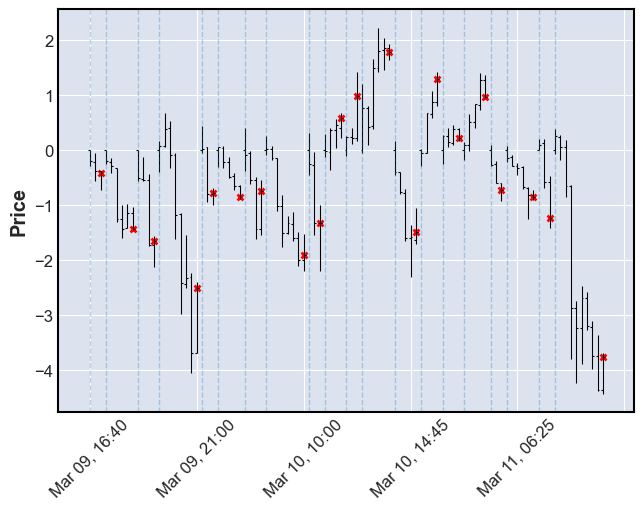

In [14]:
apds = [ 
    #mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"), 
   #mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
   mpf.make_addplot(scatter,color='r',type='scatter',marker="x"),
       ]
fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True)
for ax in axlist[:]:
    for vline in my_vlines:
        ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)

In [52]:
def get_stats(lastNsamples=0):
    final_profit = 1
    profit1=profit[-lastNsamples:]
    ind=dfmpl.iloc[np.where(~np.isnan(scatterup))[0][np.r_[-lastNsamples,-1]]].index
    equity=[1]
    for p in profit1:
        final_profit *= (1+p)
        equity.append(final_profit)
    wins=sum(p>0 for p in profit1)
    diff = ind[1].to_datetime64()-ind[0].to_datetime64()
    trading_days = int(diff)*1e-9/3600/24
    str1=f"gain% = {final_profit*100-100:.2f}%"+"\n"+\
          f"trades={len(profit1)}, wins={wins}, win%={wins/len(profit1)*100:.2f}%"+"\n"+\
          f"days={trading_days:.3g}d, trade dur={np.mean(trade_durations[-lastNsamples:]):.3g}hr"
    return str1
final_profit = 1
profit1=profit
equity=[1]
for p in profit1:
    final_profit *= (1+p)
    equity.append(final_profit)

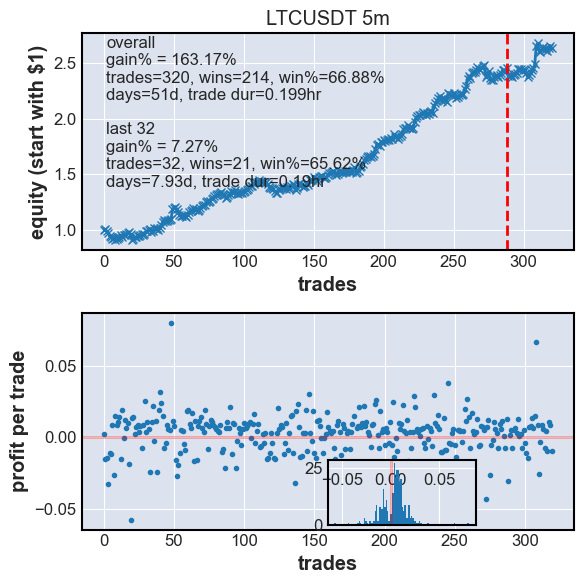

In [54]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,6))
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(
    f"{tickerpair} {interval}")
ax1.text(0.05,0.99, "overall\n"+get_stats(0),transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.05,0.59, f"last {lastNsamples}\n"+get_stats(lastNsamples),transform=ax1.transAxes,va="top",ha="left")
ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
ax2.plot(profit,".")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")

for ax in (ax1,ax2):
    ax.set_xlabel("trades")
plt.tight_layout()
ax3 = ax2.inset_axes((0.5,0.02,0.3,0.3))
ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("x",top=True, labeltop=True, bottom=False, labelbottom=False,pad=-20,direction="in")

In [17]:
confusion_matrix(true_sign, clf.predict(pred_sign))

array([[ 73,  88],
       [ 18, 141]], dtype=int64)

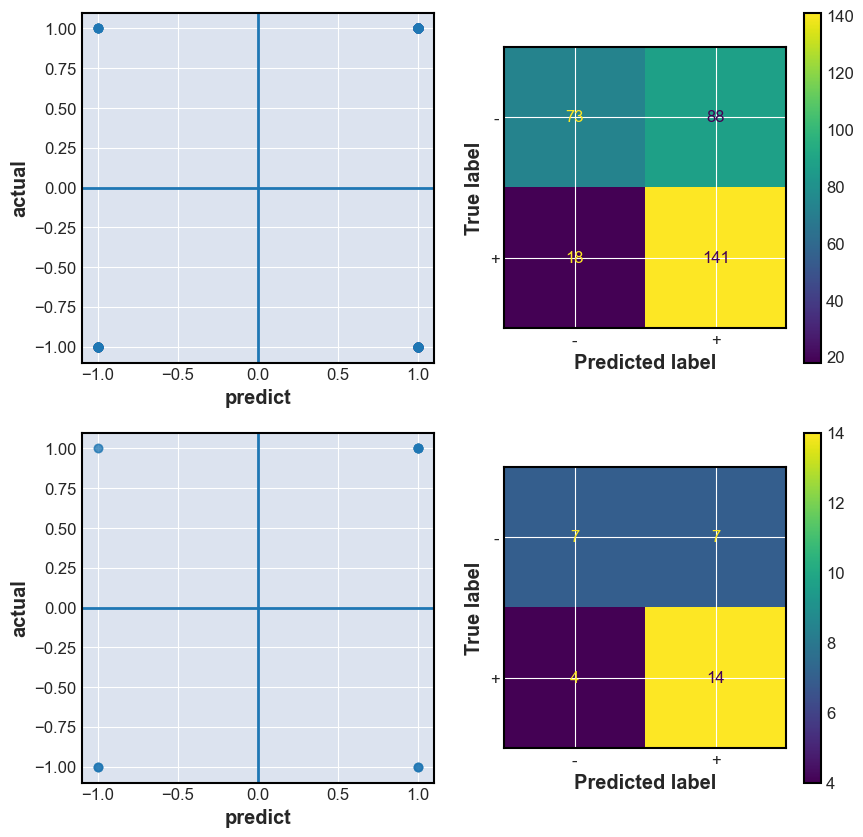

In [18]:
fig,axx=plt.subplots(2,2,figsize=(10,10))
for i,(ax1,ax2) in enumerate(axx):
    ii=0 if i==0 else lastNsamples
    ax1.scatter(clf.predict(pred_sign)[-ii:],true_sign[-ii:],alpha=0.3)
    ax1.set_xlabel("predict")
    ax1.set_ylabel("actual")
    ax1.axvline(0)
    ax1.axhline(0)
    ConfusionMatrixDisplay.from_predictions(  true_sign[-ii:],clf.predict(pred_sign)[-ii:],
            display_labels=["-","+"],ax=ax2)